<a href="https://colab.research.google.com/github/lwalsh-fio/Big-Data-Projet-TP/blob/main/TP1_MAPI3_Maligne%20-%20Walsh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Travaux pratiques: Reseaux de neurones

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

Dans ce TP nous allons implémenter les differents éléments qui composent un réseau de neurones 

# Dataset

Dans la première partie, nous allons essayer de prédire le prix de vente de biens immobiliers de la ville Boston.  
Nous allons pour cela utiliser le classique jeu de données boston house-prices, disponible directement dans la librairie de machine learning [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html)  
Commençons donc par importer le dataset:

In [ ]:
from sklearn.datasets import load_boston
dataset = load_boston()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

Nous allons donc essayer de prédire le prix des maisons à partir de 13 features présentées [ici](https://scikit-learn.org/stable/datasets/toy_dataset.html#boston-dataset).   

Commençons par séparer le dataset en 2:
* Un ensemble d'apprentissage pour entrainer le modèle
* Un ensemble de test pour tester le modèle appris

Utilisez la méthode [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) de scikit-learn pour séparer le dataset de la façon suivante:
* ```X_train``` -> les features pour entrainer le modèle
* ```y_train``` -> les prix à prédire durant l'apprentissage
* ```X_test``` -> les features pour tester le modèle
* ```y_test``` -> les prix à prédire pour tester le modèle  

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

data = np.asarray(dataset.data, dtype='float32')
target = np.asarray(dataset.target.reshape(-1, 1), dtype='float32')

X_train, X_test, y_train, y_test = train_test_split (data,target,random_state=42)

Parmi les bonnes pratiques permettant d'améliorer l'apprentissage des réseaux de neurones, il est important de normaliser les données en entrée pour obtenir un moyenne proche de 0 et une variance à 1.  
Utilisez la méthode [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) de scikit-learn pour normaliser ```X_train``` et ```X_test``` ainsi que ```y_train``` et ```y_test```:

In [ ]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler


In [ ]:
scaler_x=StandardScaler()
X_train_=scaler_x.fit_transform(X_train)
X_test_=scaler_x.transform(X_test)

scaler_y=StandardScaler()
Y_train_=scaler_y.fit_transform(y_train)
Y_test_=scaler_y.transform(y_test)

# Réseaux de neurones

Nous allons construire nos réseaux de neurones comme des successions de couches.  
Nous distinguerons, similairement aux frameworks les plus courants (Tensorflow, Pytorch, Keras ...), deux types de couches:
* des couches de poids et gradients
* des couches d'activations 

Chaque couche possèdera:
* une méthode ```forward``` qui recevra en entrée un vecteur $x$ auquel sera appliqué une transformation qui servira d'inputs pour les couches suivantes
* une méthode ```backward``` qui recevra en entrée des gradients et les retropopages vers les couches précédentes. 
* un argument ```layer_type``` permettant de définir le type de couche

La classe suivante définit la structure d'une couche:

In [ ]:
class Layer:
    def __init__(self):
        self.layer_type = 'abstract'

    def forward(self, inputs):
        pass
    
    def backward(self, grad):
        pass

Un réseau de neurones sera donc une classe:
* contenant une liste de couches
* possédant une méthode ```forward``` (qui fera appel aux méthodes ```forward``` de ses couches) qui pour un vecteur $x$ fournira une prédiction $\hat{y}$
* et une méthode ```backward``` (composition des méthodes ```backward``` de ses couches) qui rétropopagera les gradients depuis sa sortie jusqu'a ses premières couches.

![NeuralNetwork](https://github.com/DavidBert/TP-MAPI3/blob/master/layers.png?raw=1)

# Layers

Nous allons maintenant implémenter les couches de notre réseau.  
Commençons par les couches "linéaires" composées de poids $W$ et de biais $b$.  
Ces couches reçoivent en entrée un vecteur $x$ et retournent en sortie le résultat de $xW + b$.

Complétez la definition de la classe LinearLayer:
* les poids et les biais serons stockés dans un dictionnaire "params". Les poids seront une matrice $input \times output$ initialisée uniformémént entre $[-0.1, 0.1]$ (pensez à la fonction random.uniform de numpy)
* implémentez la méthode forward (vous pouvez utiliser la fonction np.matmul pour calculer $xW$), il faudra garder en mémoire le vecteur d'entrées qui sera utilisé lors de l'appel à la méthode backward:

In [ ]:
class Linear(Layer):
    def __init__(self, input_size, output_size):
        super().__init__()
        
        self.layer_type = 'linear'
        self.params ={}
        self.grads = {}
        #weights est la matrice [input x output] contenant les poids de la couche 
        self.params["weights"] = np.random.uniform(low=-0.1,high=0.1,size=(input_size,output_size))
        #biais est un vecteur de dimension: (output_size)
        self.params["bias"] = np.random.uniform(-0.1,0.1,size=(output_size))

    def forward(self, inputs):
        
        #Nous devons garder en mémoire les inputs car ils seront utilisés dans la méthode backward
        self.inputs = inputs
        return( np.matmul(inputs,  self.params["weights"]) + self.params['bias'])
    
    def backward(self, grad):
        # we need to sum gradients over the batch axis

        self.grads["weights"] = np.matmul(self.inputs.T, grad)
        self.grads["bias"] = np.sum(grad, axis=0)
        #print(self.grads["weights"].shape )
        return np.matmul(grad, self.params["weights"].T)

Testez votre layer, la cellule suivante ne doit pas renvoyer d'erreur:

In [ ]:
input_size, output_size = 10, 5
X = np.random.rand(input_size)
grads = np.random.rand(10,5)
test_linear_layer = Linear(input_size, output_size)
assert test_linear_layer.forward(X).shape == (5,)
assert test_linear_layer.backward(grads).shape == (10, 10)

## Activation Layers

Nous allons maintenant implémenter les fonctions d'activation utilisées par les neurones.  
Implémentez une fonction d'activation ainsi que sa dérivée (par exemple la fonction ReLU: $f(x) = max(0,x)$:

In [ ]:
def relu(x):
    return np.maximum(0,x)

def relu_prime(x):
    return np.where(x > 0, 1.0, 0.0)

Implémentez maintenant les couches d'activations:  
Elles seront initialisées à partir d'une fonction $f$ et de sa dérivée

In [ ]:
class Activation(Layer):
    def __init__(self, f, f_prime):
        super().__init__()
        self.layer_type = 'activation'
        self.f = f
        self.f_prime = f_prime

    def forward(self, inputs):
        #Nous devons garder en mémoire les inputs car ils seront utilisés dans la méthode backward
        self.intputs = inputs

        return (self.f(inputs))
    
    def backward(self, grad):
        """ si y = f(x) et x = g(z)
        alors dy/dz = f'(x) * g'(z)
        Dans notre cas g'(z) correspond aux gradients en entrée
        """
        return self.f_prime(self.intputs) * grad

Testez votre couche d'activation.  
La cellule suivante ne dois pas renvoyer d'erreur:

In [ ]:
relu_layer = Activation(f=relu, f_prime=relu_prime)

#forward
x = np.array([-1, 5, -2, 6])
y = relu_layer.forward(x)
assert np.array_equal(y, np.array([0, 5, 0, 6]))

#backward
incomming_grads = np.array([-0.1, 0.6, -0.4, -0.1])
grads = relu_layer.backward(incomming_grads)
assert np.array_equal(grads, np.array([-0. ,  0.6, -0. , -0.1]))

## Neural network

Nous allons maintenant définir la classe qui sera utilisée pour représenter nos réseaux de neurones.  
Un réseau de neurones possédera une liste de couches et deux méthodes: ```forward``` et ```backward```.  

Complétez la méthode ```forward``` et la méthode ```backward``` de la classe NeuralNetwork en utilisant les methodes ```forward``` et ```backward``` des couches du réseau:

In [ ]:
class NeuralNetwork:
    def __init__(self, layers):
        self.layers = layers

    def forward(self, inputs):
        self.input=inputs
        for layer in self.layers:
          inputs=layer.forward(inputs)
        return(inputs)

    def backward(self, grad):
      for layer in reversed(self.layers):
          grad=layer.backward(grad)
      

Nous avons maintenant tous les éléments constituant un réseau de neurones.  
Instanciez un reseau de neurones constitué de 3 couches:
* une couche d'entrée recevant un vecteur de dimension 13 et constituée de 40 neurones
* une couche cachée de 40 neurones
* une couche de sortie constituée d'un seul neurone

In [ ]:
net=NeuralNetwork([Linear(input_size=13,output_size=40),Activation(f=relu, f_prime=relu_prime),Linear(input_size=40,output_size=40),Activation(f=relu, f_prime=relu_prime),Linear(input_size=40,output_size=1)])


Testez votre réseau sur le jeu de test:

0.6699476943898257


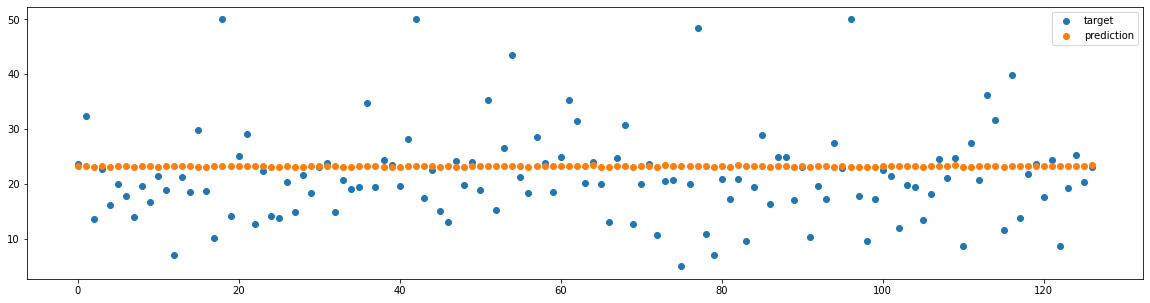

In [ ]:
from sklearn.metrics import mean_absolute_error
#print(X_test_)
Y_pred = net.forward(X_test_)
print(mean_absolute_error(Y_pred, Y_test_))
    
plt.figure(figsize=(20,5))
plt.scatter(range(len(Y_test_)), scaler_y.inverse_transform(Y_test_), label='target')
plt.scatter(range(len(Y_test_)), scaler_y.inverse_transform(Y_pred), label='prediction')
plt.legend()

# Loss function

Les prédictions du réseau sont mauvaises.  
C'est normal on ne l'a pas encore entrainé.  
Commençons par implémenter la fonction de perte qu'utilisera le réseau de neurones lors de son apprentissage.  
Nous sommes ici dans un problème de régression, nous utiliserons l'erreur quadratique moyenne (Mean Squared Error) pour apprendre notre modèle:
$$\sum_{i}^{n}\frac{(f(x_i) - y_i)^2}{n}$$  
Implémentez la fonction de perte ainsi que sa dérivée qui sera utilisée lors de la retro-propagation:

In [ ]:
class MSE():

    def loss(self, y_pred, y_true):
        #returns a scalar
        return np.mean((y_pred-y_true)**2)
    
    def grad(self, y_pred, y_true):
        #returns a tensor of gradients
        
        return 2*(y_pred-y_true)

# Optimizer

Nous allons maintenant implémenter la méthode d'optimisation utilisée durant l'apprentissage.  
Nous utiliserons ici la descente de gradient stochastique.  
La méthode est simple: à chaque pas nous allons mettre à jour les paramètres du réseau grace à la formule suivante: $w_{t+1} = w_t - \eta \nabla$ où $\eta$ est le learning rate.

In [ ]:
class SGD():
    def __init__(self, lr=0.001):
        self.lr = lr
    
    def step(self, net):
        for layer in net.layers:
            if layer.layer_type == 'linear':
                for param, grad in zip(layer.params.values(), layer.grads.values()):
                  
                  param -= self.lr * grad
                  #print(param)
                          

# Fit function

Il ne reste plus qu'à implémenter la fonction fit qui réalise une époque d'apprentissage.  
La fonction doit:
* calculer les predictions du réseau sur le batch d'apprentissage
* calculer la loss
* calculer le gradient de la loss
* retropropager les gradients
* realiser un pas d'optimisation
* retourner la perte 

In [ ]:
def fit(net, loss, optimizer, X, y):
    Y_pred = net.forward(X)
    prediction_loss=loss.loss(Y_pred,y)
    grad_loss=loss.grad(Y_pred,y)
    net.backward(grad_loss)
    optimizer.step(net)
    return prediction_loss

On peut maintenant entrainer notre réseau:

In [ ]:
%%capture
import matplotlib 
matplotlib.use('Agg')

optimizer = SGD(lr=0.01)
loss = MSE()
k=0
for i, (x, y) in enumerate(zip(X_train_, Y_train_)):
    training_loss = fit(net, loss, optimizer, np.array([x]), np.array([y]))
    y_pred = net.forward(X_test_)

    fig = plt.figure(figsize=(20,5));
     #cette boucle sert à visualiser la precision au cours des batchs
    if i%5 == 0:
      plt.scatter(range(len(Y_test_)), scaler_y.inverse_transform(Y_test_), label='target');
      plt.scatter(range(len(Y_test_)), scaler_y.inverse_transform(y_pred), label='prediction');
      plt.legend();
      plt.savefig(f'test{100 + k}.png');
      plt.close(fig);
      k+=1
print(mean_absolute_error(Y_test_,y_pred))

In [ ]:
print('mean absolute error: ', mean_absolute_error(y_pred, Y_test_))

mean absolute error:  0.3364086432764178


In [ ]:
%%capture
!apt-get update
!apt-get install imagemagick
!convert -delay 40 *.png animated_chart.gif

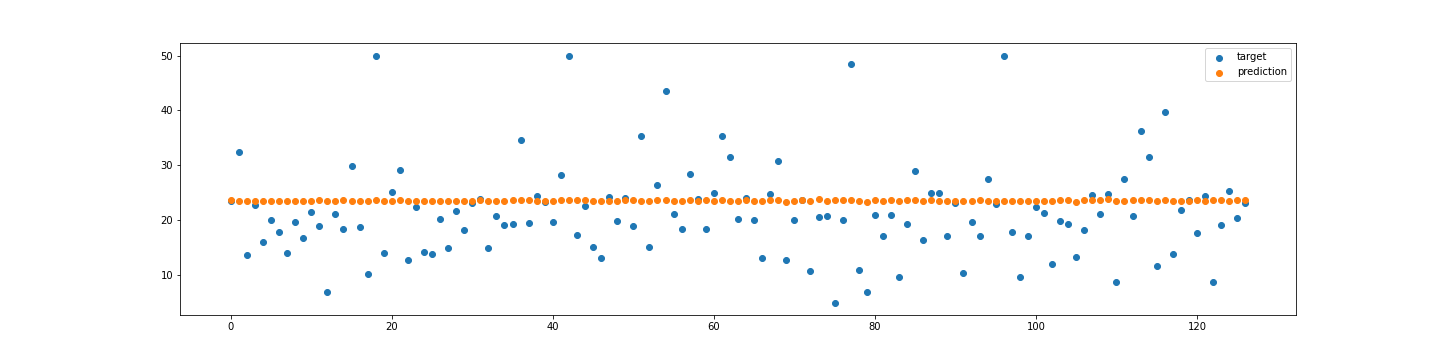

In [ ]:
from IPython.display import Image
Image(open('animated_chart.gif','rb').read())

Les cellules suivantes montrent la progression de l' entrainement durant le batch:

Nous venons de réaliser un entrainement sur une époque.  
Entrainez votre réseau sur 10 époques et comparez les resultats:

0.3094955536177616
0.3114665134404432
0.3076994685529982
0.297976887692492
0.3078006264689197
0.3053215899919773
0.3058299151925476
0.3040860961350032
0.3008274324762776
0.2973631509068387
0.2973631509068387


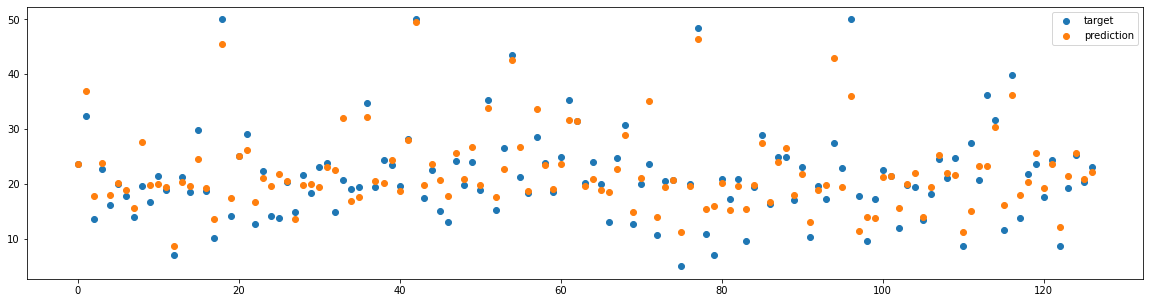

In [ ]:
for epoch in range(10):
  for i, (x, y) in enumerate(zip(X_train_, Y_train_)):
    training_loss = fit(net, loss, optimizer, np.array([x]), np.array([y]))
    y_pred = net.forward(X_test_)
  print(mean_absolute_error(Y_test_,y_pred))





print(mean_absolute_error(y_pred, Y_test_))
    
plt.figure(figsize=(20,5))
plt.scatter(range(len(Y_test_)), scaler_y.inverse_transform(Y_test_), label='target')
plt.scatter(range(len(Y_test_)), scaler_y.inverse_transform(y_pred), label='prediction')
plt.legend()

# Digits

Essayons maintenant notre classe ```NeuralNetwork``` sur un problème de classification.  
Nous allons chercher à classifier des chiffres manuscrits à partir des pixels.  
Nous utiliserons pour cela le dataset [digits de scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits

dataset = load_digits()

Affichez les 10 premiers éléments du dataset:

In [ ]:
data=np.asarray(dataset.data, dtype='float32')

In [ ]:
target[0:12]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1], dtype=int32)

Similairement au dataset précédent, séparez votre jeu de données en deux et normalisez les vecteurs d'entrées. (Pas la peine cette fois çi de normaliser les $y$)


In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

data = np.asarray(dataset.data, dtype='float32')
target = np.asarray(dataset.target, dtype='int32')

X_train, X_test, y_train, y_test = train_test_split (data,target,random_state=42)
scaler_x=StandardScaler()
X_train_plot=X_train
X_test_plot=X_test
X_train=scaler_x.fit_transform(X_train)
X_test=scaler_x.transform(X_test)


#y_train_2=np.asarray(to_categorical(y_train), dtype='int32')
#y_test=np.asarray(to_categorical(y_test), dtype='int32')





In [ ]:
print(y_test.shape)

(450,)


In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1347, 64)
(450, 64)
(1347,)
(450,)


# Cross entropy

Nous sommes cette fois-ci en présence d'un problème de classification.  
La fonction de perte MSE n'est plus appropriée pour notre problème.  
Nous allons utiliser ici la [cross-entropy.](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression) comme fonction de perte:  
En considerant que notre réseau produit en sortie un vecteur $\hat{y}$ de dimension $C$.  
Où $C$ correspond au nombre de neurones de la couche de sortie (chaque neurone correspond à une classe).  
Alors la cross-entropy entre le vecteur prédit par le réseau et la véritable classe notée $c$ peut s'écrire:


$$
\begin{align}
 L(\hat{y}, c) &= -log(\frac{e^{\hat{y_c}}}{\sum_{i}^{C}e^\hat{y_c}_k}) \\ 
 &= - \hat{y_c} + log(\sum_{i}^{C}e^\hat{y_c}_k)
 \end{align}
 $$

In [ ]:
def softmax(x):
    return np.exp(x) / np.exp(x).sum(axis=-1,keepdims=True)

class CrossEntropy():

    def loss(self, logits, y_true):
        logits_for_answers = logits[np.arange(len(logits)), y_true]
        xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
        return xentropy



    def grad(self, logits, y_true):
        ones_for_answers = np.zeros_like(logits)
        ones_for_answers[np.arange(len(logits)), y_true] = 1
        y_softmax = softmax(logits)
        return (- ones_for_answers + y_softmax) / logits.shape[0]

Instanciez un reseau de neurones capable de prédire la classe d'une image:

In [ ]:
Layers=[Linear(input_size=64,output_size=10),Activation(f=relu, f_prime=relu_prime),Linear(input_size=10,output_size=10)]
net = NeuralNetwork(Layers)
loss=CrossEntropy()
optimizer = SGD(lr=0.05)

In [ ]:
training_loss = fit(net, loss, optimizer, X_train, y_train)
y_pred_2= net.forward(X_test)

Calculez la précision de votre réseau sur le jeu de test. (Vous pouvez pour cela utiliser la fonction [acuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) de scikit-learn)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
prediction2=np.zeros(y_pred_2.shape[0])
for i in range(y_pred_2.shape[0]):  
  probas = softmax(y_pred_2[i])
  prediction2[i]= np.argmax(probas)

In [ ]:
print(accuracy_score(y_test,prediction2))

0.09111111111111111


La fonction suivante permet de visualiser nos prédictions

In [ ]:
scaler=StandardScaler()

In [ ]:
def plot_prediction(net, sample_idx=range(3), classes=range(10),pred_return=False):
    
    for idx in sample_idx:
        plt.figure()
        logits = net.forward(X_test[idx])
        probas = softmax(logits)
        prediction = np.argmax(probas)

        fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
        ax0.imshow(X_test_plot[idx].reshape(8,8), cmap=plt.cm.gray_r,
                   interpolation='nearest')
        ax0.set_title("True image label: %d" % y_test[idx]);
        ax1.bar(classes, np.eye(len(classes))[y_test[idx]], label='true')
        ax1.bar(classes, probas, label='prediction', color="red")
        ax1.set_xticks(classes)

        ax1.set_title('Output probabilities (prediction: %d)'
                      % prediction)
        ax1.set_xlabel('Digit class')
        ax1.legend()
    if pred_return==True:
      return(prediction)
    else:
      return(None)

<Figure size 432x288 with 0 Axes>

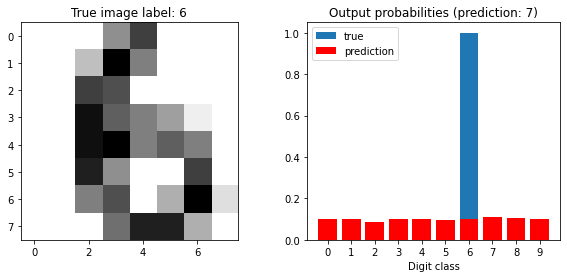

<Figure size 432x288 with 0 Axes>

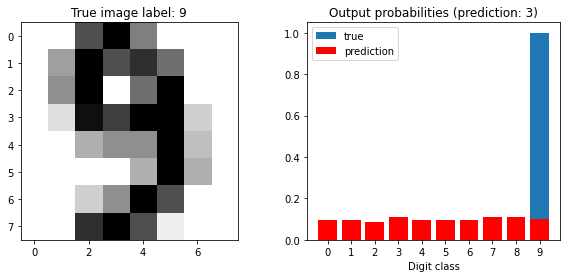

<Figure size 432x288 with 0 Axes>

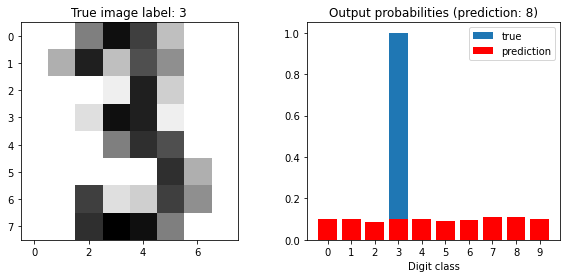

In [ ]:
plot_prediction(net, sample_idx=range(3))

Nous allons cette fois-çi, utiliser des mini-batchs durant notre apprentissage.  
La fonction suivante permet d' itérer sur des mini-batchs:

In [ ]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=True):
    assert inputs.shape[0] == targets.shape[0]
    if shuffle:
        indices = np.arange(inputs.shape[0])
        np.random.shuffle(indices)
    for start_idx in range(0, inputs.shape[0] - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

Et la fonction suivant de réaliser une époque d'apprentissage à l'aide de mini-batchs:

In [ ]:
def fit_one_epoch(X, y_true):
    for x, y in iterate_minibatches(X, y_true, 32):
        training_loss = fit(net, loss, optimizer, x, y)
        
    return training_loss.mean()

Entrainez votre reseau sur 15 époques.  
A chaque époque, calculez votre précision sur le jeu de d'apprentissage et sur le jeu de test et affichez les sur un même graphique une fois l'entrainement terminé.

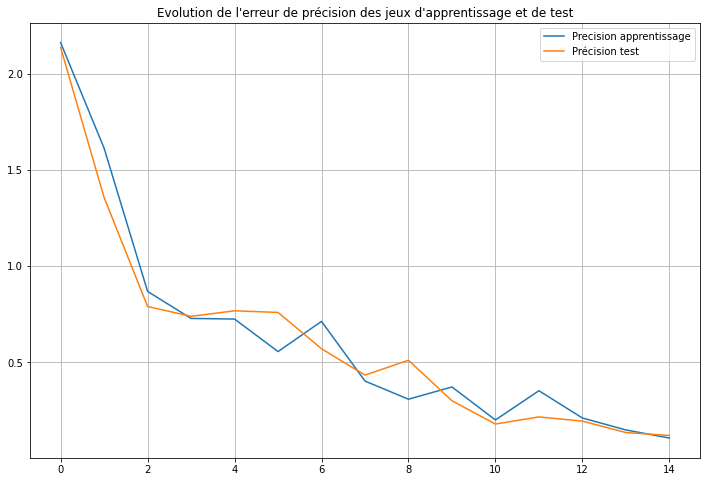

In [ ]:
pres_train=[]
pres_test=[]
for epoch in range(15):
  pres_train+=[fit_one_epoch(X_train, y_train)]
  pres_test+=[fit_one_epoch(X_test, y_test)]
  
plt.figure(figsize=(12,8))
plt.title("Evolution de l'erreur de précision des jeux d'apprentissage et de test" )
plt.plot(pres_train,label='Precision apprentissage')
plt.plot(pres_test,label='Précision test')
plt.grid()
plt.legend()

Affichez votre précision sur le jeu de test et visualisez vos prédictions à l'aide de la fonction plot_prediction)

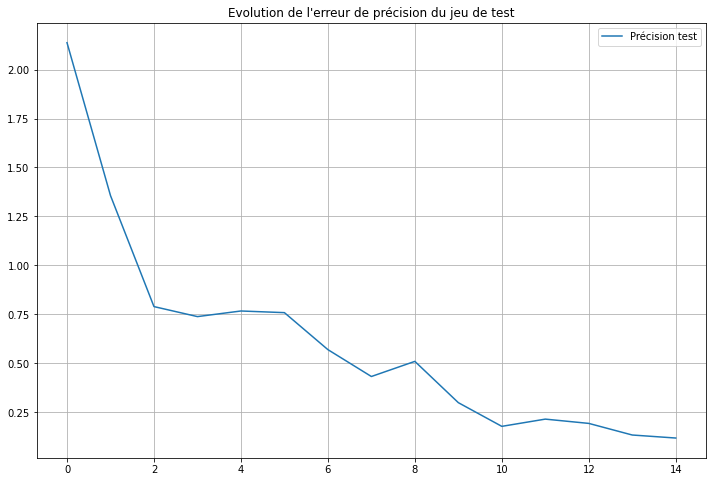

In [ ]:
plt.figure(figsize=(12,8))
plt.title("Evolution de l'erreur de précision du jeu de test" )
plt.plot(pres_test,label='Précision test')
plt.grid()
plt.legend()

<Figure size 432x288 with 0 Axes>

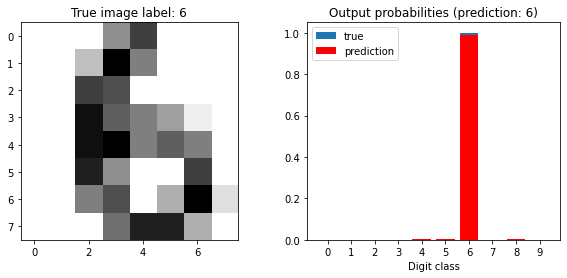

<Figure size 432x288 with 0 Axes>

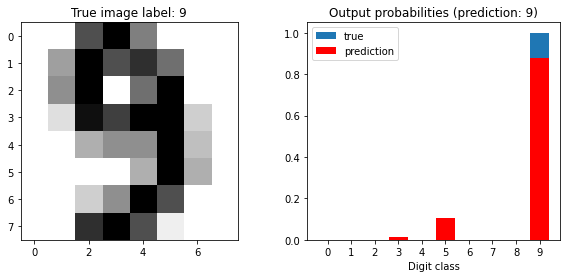

<Figure size 432x288 with 0 Axes>

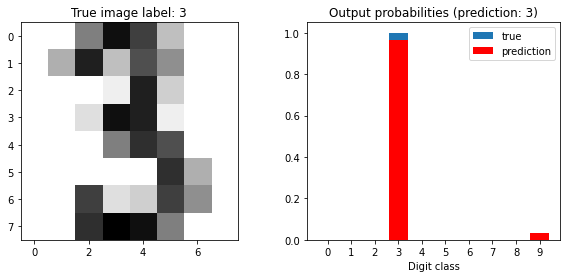

<Figure size 432x288 with 0 Axes>

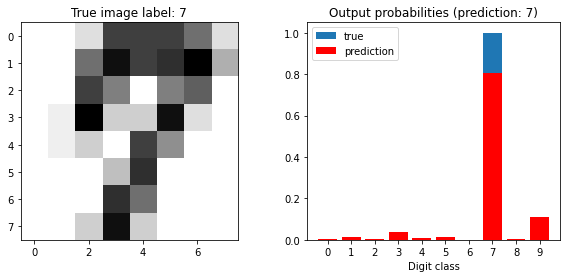

In [ ]:
prediction=np.zeros(y_pred_15.shape[0])
y_pred_15=net.forward(X_test)
for i in range(y_pred_15.shape[0]):  
  probas = softmax(y_pred_15[i])
  prediction[i]= np.argmax(probas)
plot_prediction(net, sample_idx=range(4),classes=range(10),pred_return=None)

Essayez d'afficher votre matrice de confusion en vous inspirant de [ce code:](https://scikit-learn.org/dev/auto_examples/classification/plot_digits_classification.html#sphx-glr-auto-examples-classification-plot-digits-classification-py) 

In [ ]:
from sklearn import  metrics

Confusion matrix:
[[42  0  0  0  1  0  0  0  0  0]
 [ 0 36  0  0  1  0  0  0  0  0]
 [ 0  1 37  0  0  0  0  0  0  0]
 [ 0  0  2 43  0  1  0  0  0  0]
 [ 0  1  0  0 54  0  0  0  0  0]
 [ 0  0  0  0  0 58  1  0  0  0]
 [ 1  0  0  0  0  0 44  0  0  0]
 [ 0  0  0  0  0  1  0 40  0  0]
 [ 0  1  0  0  0  1  0  0 36  0]
 [ 0  0  0  1  0  0  0  0  1 46]]


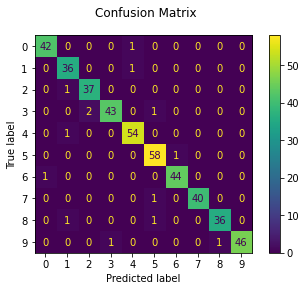

In [ ]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, prediction)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

In [ ]:
print(
    f"Classification report :\n"
    f"{metrics.classification_report(y_test, prediction)}\n"
)

Classification report :
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        43
           1       0.92      0.97      0.95        37
           2       0.95      0.97      0.96        38
           3       0.98      0.93      0.96        46
           4       0.96      0.98      0.97        55
           5       0.95      0.98      0.97        59
           6       0.98      0.98      0.98        45
           7       1.00      0.98      0.99        41
           8       0.97      0.95      0.96        38
           9       1.00      0.96      0.98        48

    accuracy                           0.97       450
   macro avg       0.97      0.97      0.97       450
weighted avg       0.97      0.97      0.97       450




Affichez les exemples sur lesquels le réseau se trompe.  
Auriez-vous donné une meilleure prédiction que le réseau sur ces exemples?

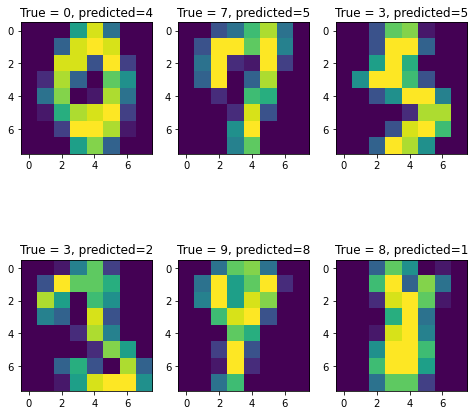

In [ ]:
k=0
plt.figure(figsize=(8,8))
for i in range(prediction.shape[0]):
  if prediction[i]!=y_test[i] and k<6:
    k+=1
    plt.subplot(2,3,k)
    plt.title('True = %i, predicted=%i'%(y_test[i],prediction[i]))
    plt.imshow(X_test_plot[i].reshape(8,8))

Sur l'image 1,2 et 4, on aurait trouvé la bonne valeur mais pour les autres images non. Donc le réseau est quand même très performant.